# Praca domowa IV
### Jan Gąska
W tej pracy domowej przyjrzymy się bardziej z bliska algorytmowi Support Vector Machine(SVM) i dokonamy na nim odrobinę eksperymentów

## Import potrzebnych bibliotek

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from dalex.datasets import load_apartments

## Ramka danych apartments

In [164]:
df_apartments = load_apartments()
#Zobaczmy jak prezentuje się nasza ramka
df_apartments.head()

,m2_price,construction_year,surface,floor,no_rooms,district
1,5897,1953,25,3,1,Srodmiescie
2,1818,1992,143,9,5,Bielany
3,3643,1937,56,1,2,Praga
4,3517,1995,93,7,3,Ochota
5,3013,1992,144,6,5,Mokotow


## Zwięzłe EDA
Przed przejściem do pracy zajmijmy się dokonaniem szybkiej eksploracji danych, być może coś zwróci naszą uwagę?

In [10]:
df_apartments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   m2_price           1000 non-null   int64 
 1   construction_year  1000 non-null   int64 
 2   surface            1000 non-null   int64 
 3   floor              1000 non-null   int64 
 4   no_rooms           1000 non-null   int64 
 5   district           1000 non-null   object
dtypes: int64(5), object(1)
memory usage: 54.7+ KB


Idalnie, nie ma żadnych braków w danych (brak wartości null), oraz mamy 1000 wierszy z danymi oraz tylko jedną kolumnę z danymi nie numerycznymi.  
"Zadaniem" ramki jest dopasowanie ceny **m2_price** na podstawie informacji.  
Ponieważ nasz *target* nie jest na ostatnim miejscu w tabeli, zmieńmy tą kolejność.

In [165]:
df_apartments = df_apartments[['construction_year','surface','floor','no_rooms','district','m2_price']]
df_apartments.head()
#Od razu lepiej

,construction_year,surface,floor,no_rooms,district,m2_price
1,1953,25,3,1,Srodmiescie,5897
2,1992,143,9,5,Bielany,1818
3,1937,56,1,2,Praga,3643
4,1995,93,7,3,Ochota,3517
5,1992,144,6,5,Mokotow,3013


Pomimo iż nazwy kolumn są dość deskryptywne, to i tak zamieszczę ich znaczenie dla celów całkowitej klarowności:  
**m2_price** - cena na metr kwadratowy  
**construction_year** - rok budowy apartamentu  
**surface** - pole powierzchni apartamentu w metrach kwadratowych  
**floor** - piętro  
**no_rooms** - liczba pokoi (skorelowana z polem powierzchni)  
**district** - dzielnica w której zlokalizowany jest apartament, (faktor z 10 poziomami jako dane)

array([[<AxesSubplot:title={'center':'m2_price'}>,
        <AxesSubplot:title={'center':'construction_year'}>],
       [<AxesSubplot:title={'center':'surface'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'no_rooms'}>, <AxesSubplot:>]],
      dtype=object)

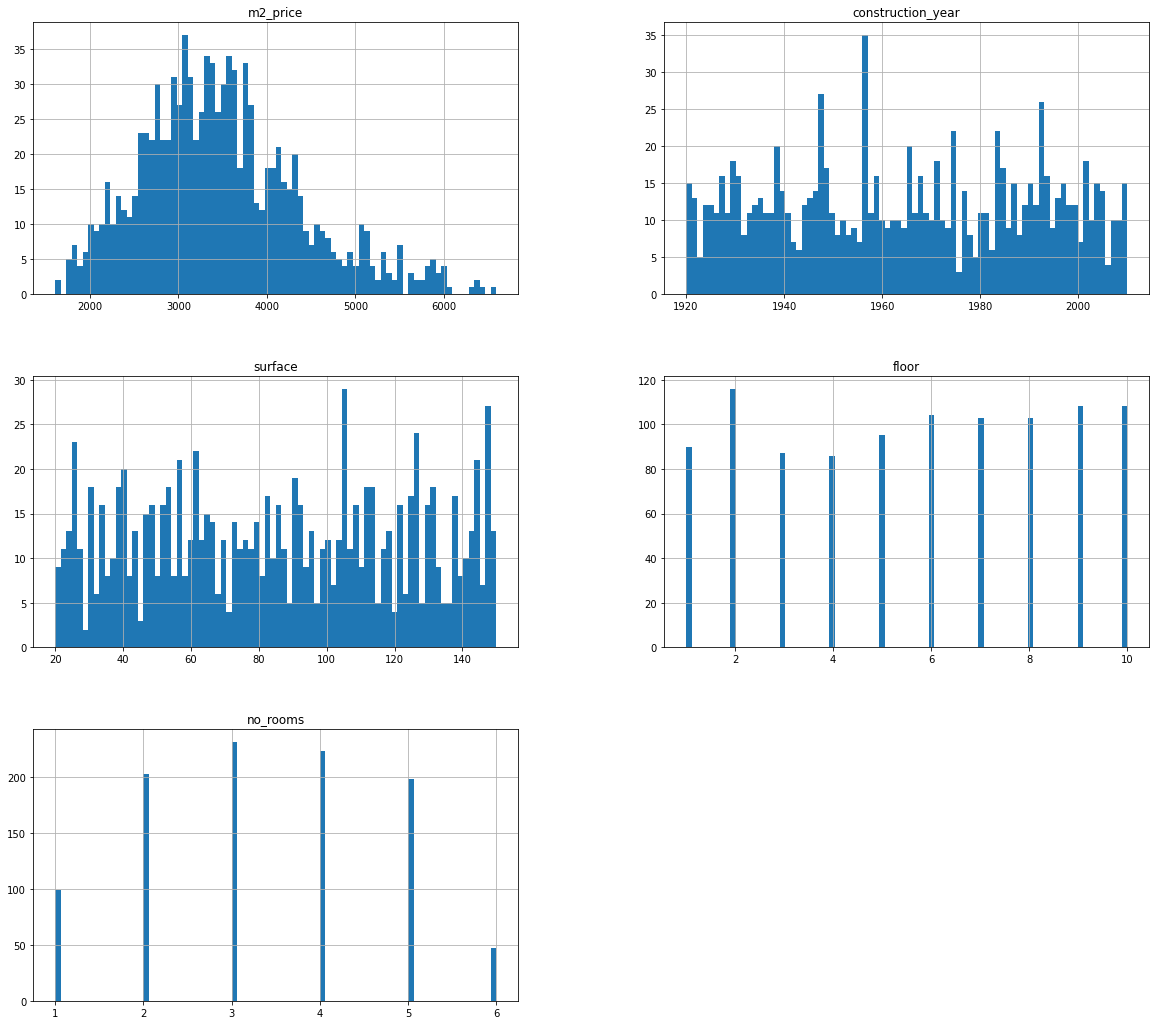

In [11]:
df_apartments.hist(bins = 80,figsize = (20,18))

Dość złą informacją są poszczególne rozkłady naszych zmiennych, gdyż żadna,z wyjątkiem jednej, choć w niedużym stopniu, z nich nie reprezentuje rozkładu Gausowskiego. Jednakże jest też światło w tunelu, zmienna floor jest dość jednostajnie rozdystrybuowana, co daje nam potencjalną informację o pozbyciu się ów kolumny z analizy bez straty prezyzji.

Dobrze dokonajmy sprawdzenia korelacji danych. Wiemy od administratora danych, iż dana **no_rooms** jest skorelowana z daną **surface**, zobaczmy czy rzeczywiście tak jest.

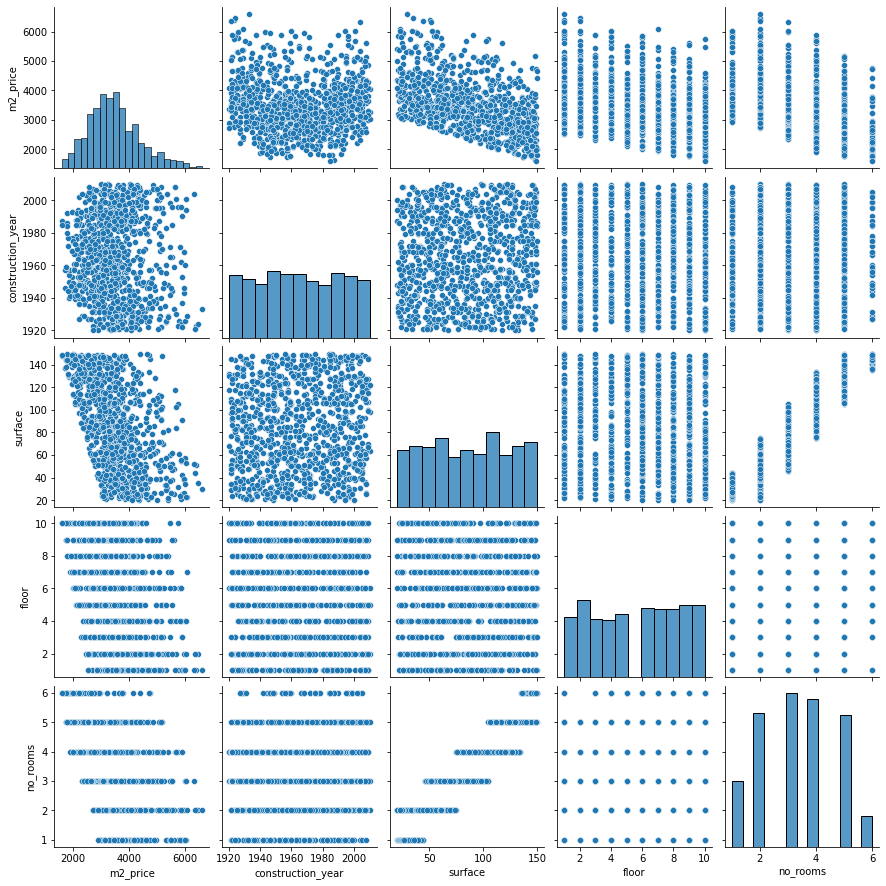

In [12]:
sns.pairplot(df_apartments)

Rzeczywiście dane są skorelowane, co więcej można zaobserwować takżę lekką korelację dla **m2_price** oraz **surface**.

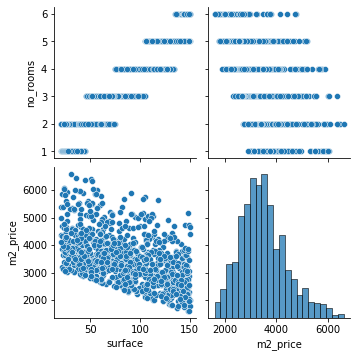

In [36]:
sns.pairplot(df_apartments,y_vars = ['no_rooms','m2_price'], x_vars = ['surface','m2_price'])

Poniżej widzimy, iż dane **construction_year** oraz **surface** nie mają zbytniej korelacji.

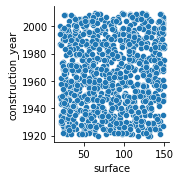

In [37]:
sns.pairplot(df_apartments,y_vars='construction_year',x_vars='surface')

Na sam koniec dokonajmy stworzenia mapy korelacji.

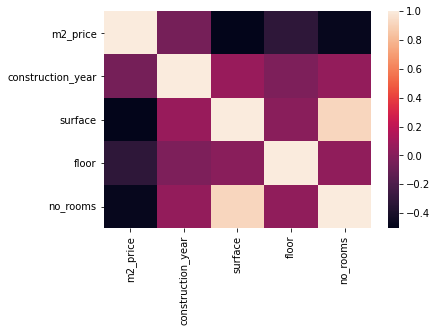

In [39]:
Korelacja = df_apartments.corr()
sns.heatmap(Korelacja,annot = False)
plt.show()

Pozytywną korelacje mamy dla pary **surface** oraz **no_rooms**, podczas gdy negatywną dla par **no_rooms** i **m2_price** oraz **m2_price** oraz **surface**.

## Ramka danych Wine z sklearn
Jako drugą ramkę wybrałem **Wine** znajdującą się w pakiecie sklearn data. Zawiera ona 13 zmiennych numerycznych, więc spełnia założenia zadania.  
Ideą klasyfikacji powyższej ramki jest stwierdzenie, jakiej klasy wina jest poszczególna sztuka. W klasyfikacji przyjęto, że:  
0 - klasa stołowa wina  
1 - klasa regionalna wina  
2 - klasa jakościowa wina

In [61]:
df_wine_target.unique()

array([0, 1, 2])

In [48]:
from sklearn.datasets import load_wine
df_raw = load_wine(as_frame = True)
df_wine = df_raw['data']
df_wine_target = df_raw['target']

## Zwięzłe EDA
Zajmijmy się teraz EDA dla drugiej z ramek danych, co może skrywać się weń?

In [59]:
df_wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [62]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

I kolejny trafiony, zatopionym nasza ramka ponownie nie zawiera żadnych wartości null oraz jej wszystkie wartości są numeryczne.  
**Uwaga**, ramka zawiera jedynie 178 wierszy! Będzie trzeba na to zwrócić uwagę w pre-procesingu i nie usuwać zanadto wierszy przy np. obcinaniu outlierów.

array([[<AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'malic_acid'}>,
        <AxesSubplot:title={'center':'ash'}>,
        <AxesSubplot:title={'center':'alcalinity_of_ash'}>],
       [<AxesSubplot:title={'center':'magnesium'}>,
        <AxesSubplot:title={'center':'total_phenols'}>,
        <AxesSubplot:title={'center':'flavanoids'}>,
        <AxesSubplot:title={'center':'nonflavanoid_phenols'}>],
       [<AxesSubplot:title={'center':'proanthocyanins'}>,
        <AxesSubplot:title={'center':'color_intensity'}>,
        <AxesSubplot:title={'center':'hue'}>,
        <AxesSubplot:title={'center':'od280/od315_of_diluted_wines'}>],
       [<AxesSubplot:title={'center':'proline'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

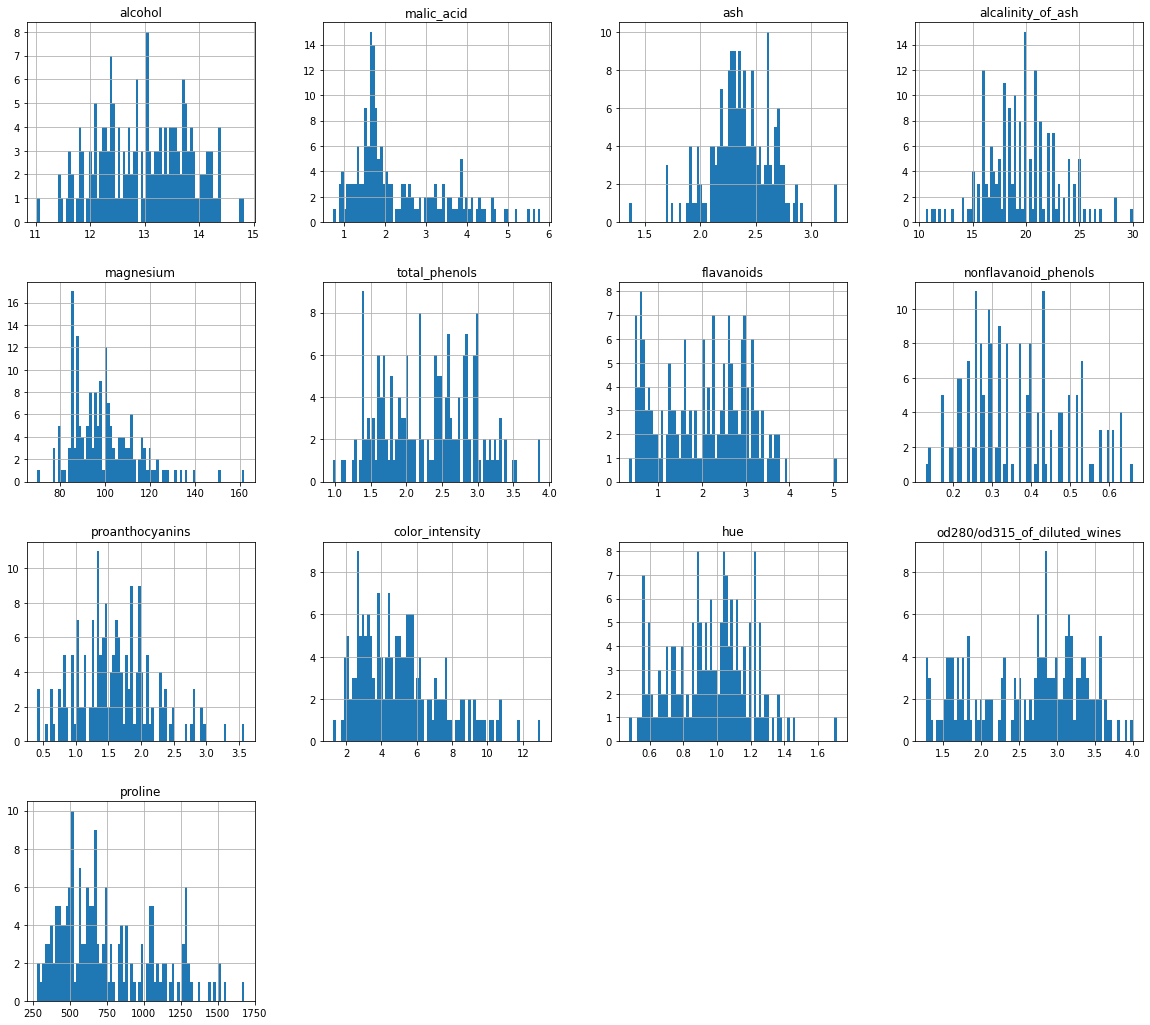

In [64]:
df_wine.hist(bins = 80,figsize = (20,18))

Podane rozkłady, w większości, są pewnym przybliżeniem rozkładu Gaussa, jednakże przez niedużą ilość danych otrzymaliśmy dość rzadką dystrybucję. Również w tej ramce danych możemy doszukać się znacznie większej ilości outlierów, jednakże, jak już wspomniałem, usuwanie ich wiąże się także z ryzykiem.

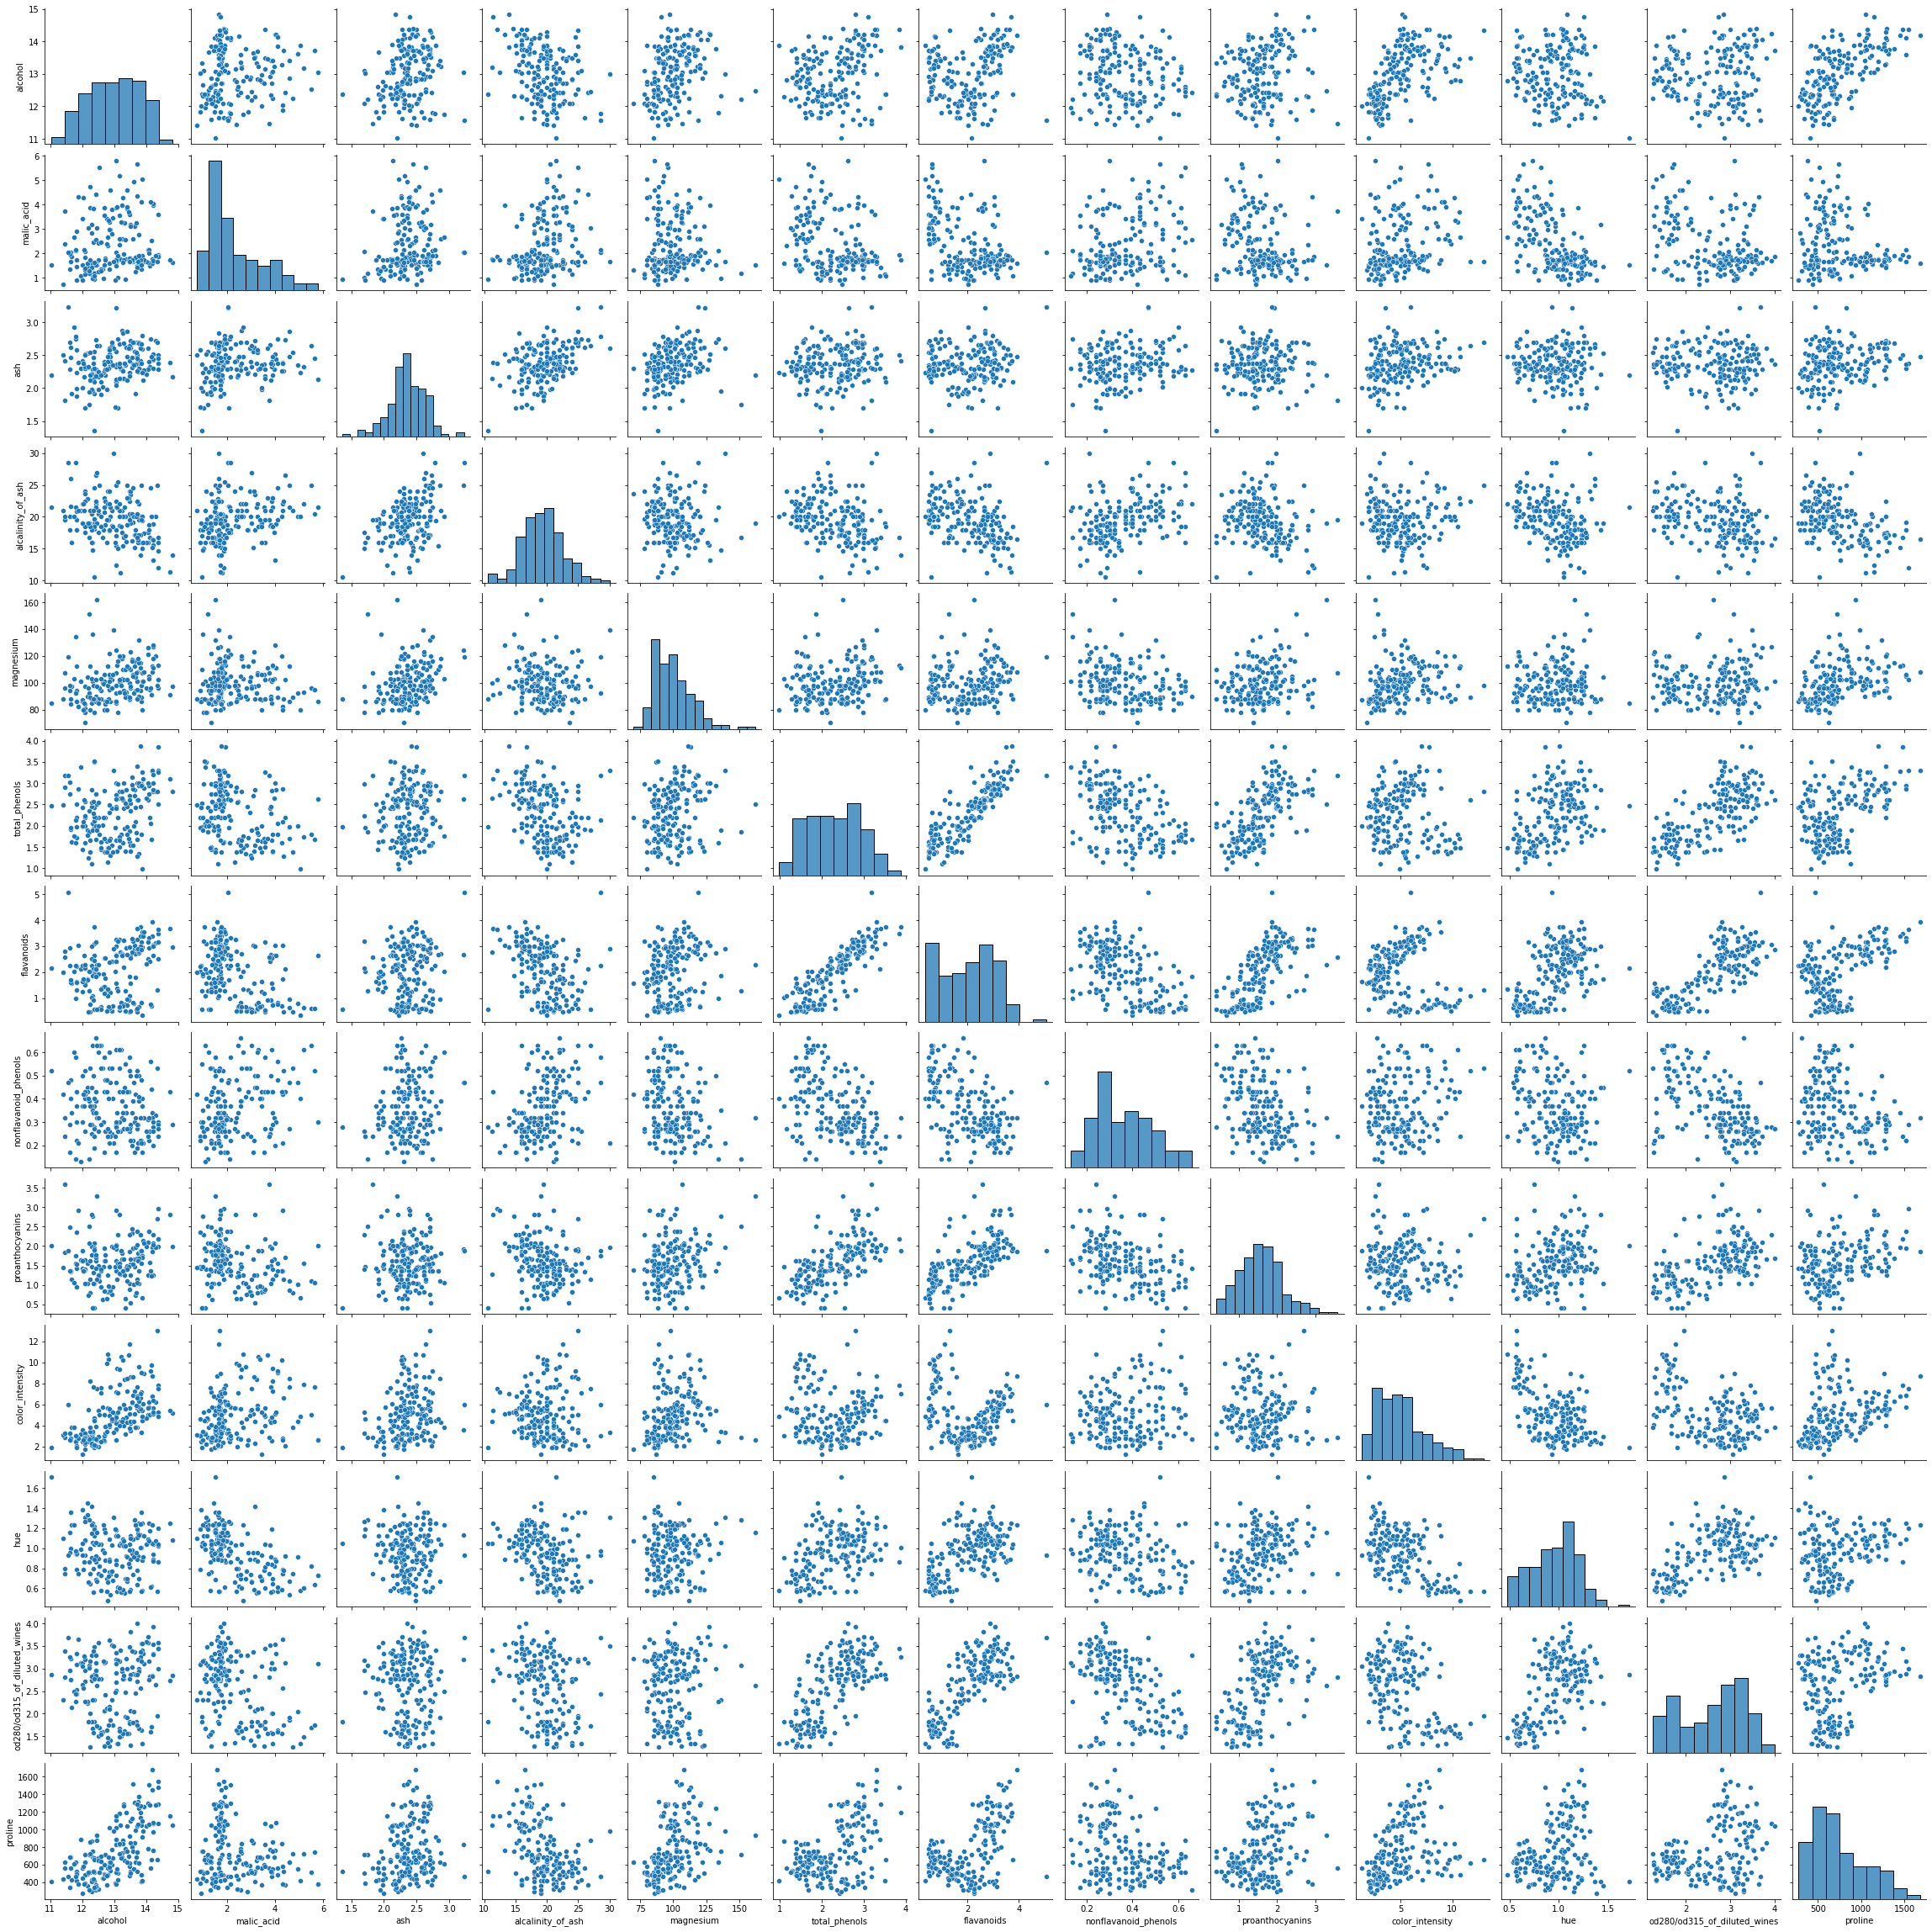

In [66]:
sns.pairplot(df_wine)

Ok, to dość spora ilość korealacji, jednakże okazuje się iż istnieje kilka silniejszych korelacji.

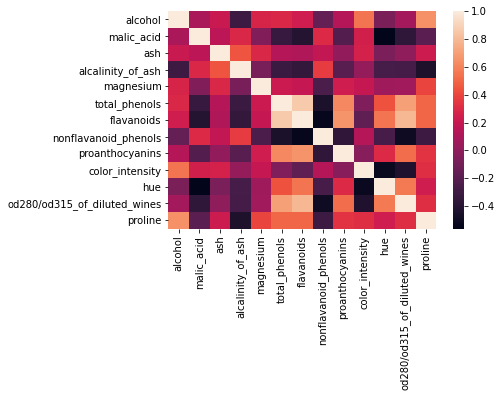

In [67]:
Korelacja = df_wine.corr()
sns.heatmap(Korelacja,annot = False)
plt.show()

## Niewielki pre-processing
Ponieważ odstąpie od usunięcia outlierów, w preprocesingu ograniczę się do zakodowania zmiennych kategorycznych oraz do zeskalowania danych za pomocą standaryzacji oraz normalizacji.  
Ponieważ zbiór danych **wine** zawiera wyłącznie wartości numeryczne, nie ma wymogu użycia kodowania zmiennych.  
Dla zwięzłosci i przyjrzystości danych zastosujmy LabelEncoder, w innych pracach dowiodłem, iż przeważnie LabelEndoder jest równoważny OneHotEncoderowi w klasyfikacji.

In [166]:
df_apartments = pd.get_dummies(df_apartments, columns = ['district'])
# Zobaczmy jak prezentują sie dane

In [81]:
df_apartments.head()

,construction_year,surface,floor,no_rooms,m2_price,district_Bemowo,district_Bielany,district_Mokotow,district_Ochota,district_Praga,district_Srodmiescie,district_Ursus,district_Ursynow,district_Wola,district_Zoliborz
1,1953,25,3,1,5897,0,0,0,0,0,1,0,0,0,0
2,1992,143,9,5,1818,0,1,0,0,0,0,0,0,0,0
3,1937,56,1,2,3643,0,0,0,0,1,0,0,0,0,0
4,1995,93,7,3,3517,0,0,0,1,0,0,0,0,0,0
5,1992,144,6,5,3013,0,0,1,0,0,0,0,0,0,0


Zajmijmy się podziałem na zbiroy testowe oraz treningowe naszych danych.

In [50]:
df_wine_tab = df_wine.join(df_wine_target)
df_wine_tab.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [174]:
indexes = [0,1,2,3,5,6,7,8,9,10,11,12,13,14]
#Zajmijmy się dokonaniem standaryzacji oraz normalizacji

df_wine_normalized = df_wine_tab.copy()
df_apartments_normalized = df_apartments.copy()

df_wine_standardized = df_wine_tab.copy()
df_apartments_standardized = df_apartments.copy()
#Normalizacja 
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()
df_wine_normalized.iloc[:,:-1] = scalar.fit_transform(df_wine_normalized.iloc[:,:-1])
df_apartments_normalized.iloc[:,indexes] = scalar.fit_transform(df_apartments_normalized.iloc[:,indexes])

from sklearn.preprocessing import StandardScaler
# Standaryzacja
scalar_2 = StandardScaler()
df_wine_standardized.iloc[:,:-1] = scalar_2.fit_transform(df_wine_standardized.iloc[:,:-1])
df_apartments_standardized.iloc[:,indexes] = scalar_2.fit_transform(df_apartments_standardized.iloc[:,indexes])


## Podział na zbiory testowy oraz treningowy
W tym punkcie dokonajmy podziału na zbiory testowe oraz treningowe każdej z naszych czterech przygotowanych ramek danych.  
Dla tabeli wines wykorzystamy opcję stratify w podziale, gdyż jest to niezrównoważona i niewielka ramka.

In [75]:
df_wine_tab['target'].value_counts()

1    71
0    59
2    48
Name: target, dtype: int64

In [175]:
#Standaryzacja
wine_s_train, wine_s_test, y_wine_s_train, y_wine_s_test = train_test_split(df_wine_standardized, df_wine_standardized['target'], test_size=0.40, random_state=33, stratify=df_wine_standardized['target'])

apart_s_train, apart_s_test, y_apart_s_train, y_apart_s_test = train_test_split(df_apartments_standardized, df_apartments_standardized['m2_price'], test_size=0.40, random_state=124)
#Normalizacja
wine_n_train, wine_n_test, y_wine_n_train, y_wine_n_test = train_test_split(df_wine_normalized, df_wine_normalized['target'], test_size=0.40, random_state=334, stratify=df_wine_normalized['target'])

apart_n_train, apart_n_test, y_apart_n_train, y_apart_n_test = train_test_split(df_apartments_normalized, df_apartments_normalized['m2_price'], test_size=0.40, random_state=1244)

#Brak
wine_train, wine_test, y_wine_train, y_wine_test = train_test_split(df_wine_tab, df_wine_tab['target'], test_size=0.40, random_state=3334, stratify=df_wine_tab['target'])

apart_train, apart_test, y_apart_train, y_apart_test = train_test_split(df_apartments, df_apartments['m2_price'], test_size=0.40, random_state=434)

## Przygotowanie modelu
Przygotujmy nasz model SVM, na którym będziemy wykonywać operacje.

### SVM bez skalowania zbiór apartments
Zaczniemy nasze dywagacje od testów bez użycia skalowania.  
Lecz najpierw przygotujmy narzędzie do wypisywania statystyk naszego modelu.

In [260]:
#Potrzebujemy funkcji dla klasyfikacji oraz dla regresji
def print_scores_wines(model, sets):
    x_train , x_test, y_train , y_test = sets
    y_predict_train = model.predict(x_train)
    y_predict_test = model.predict(x_test)
    
    print(
        "Accuracy (Train):",  accuracy_score(y_train, y_predict_train),
        "\nAccuracy (Test):",accuracy_score(y_test, y_predict_test))

Jako metrykę dla zadania regresji zastosuję błąd średniokwadratowy.

In [253]:
def print_scores_apartments(model,sets):
    X_train_ , X_test_, y_train_ , y_test_ = sets
    print('MSE (train): ', mean_squared_error(y_train_, model.predict(X_train_), squared=False))
    print('MSE (test): ', mean_squared_error(y_test_, model.predict(X_test_), squared=False))   

In [195]:
from sklearn.svm import SVC
SVC_ns = SVC()
model_1 = SVC_ns.fit(apart_train,y_apart_train)

In [242]:
print_socres_apartments(model_1,[apart_train,apart_test,y_apart_train,y_apart_test])

MSE (train):  668.7243228715403
MSE (test):  707.5422390218127


Teraz powtórzmy powyższą operację, tylko dla danych poddanych normalizacji oraz standaryzacji.  
Zacznijmy od standaryzacji i od zbioru apartments.

In [176]:
SVC_s = SVC()
model_2 = SVC_s.fit(apart_s_train,y_apart_s_train)

In [243]:
print_socres_apartments(model_2,[apart_s_train,apart_s_test,y_apart_s_train,y_apart_s_test])

MSE (train):  904.4803342251284
MSE (test):  917.8255798352975


In [181]:
#Teraz dla znomralizowanych
SVC_n = SVC()
model_3 = SVC_n.fit(apart_n_train,y_apart_n_train)

In [244]:
print_socres_apartments(model_3,[apart_n_train,apart_n_test,y_apart_n_train,y_apart_n_test])

MSE (train):  920.411583658818
MSE (test):  894.7449147662143


Teraz przejdźmy do zbioru wines, jak na razie na "czystym" zbiorze.

In [191]:
SVC_w = SVC(probability = True)
model_4 = SVC_w.fit(wine_train,y_wine_train)

In [247]:
print_scores_wines(model_4,[wine_train,wine_test,y_wine_train,y_wine_test])

Accuracy (Train): 0.660377358490566 
Accuracy (Test): 0.7083333333333334


In [199]:
#Standaryzacja
SVC_w_s = SVC(probability = True)
model_5 = SVC_w_s.fit(wine_s_train,y_wine_s_train)

In [248]:
print_scores_wines(model_5,[wine_s_train,wine_s_test,y_wine_s_train,y_wine_s_test])

Accuracy (Train): 1.0 
Accuracy (Test): 1.0


In [201]:
#Normalizacja
SVC_w_n = SVC(probability = True)
model_6 = SVC_w_n.fit(wine_n_train,y_wine_n_train)

In [249]:
print_scores_wines(model_5,[wine_n_train,wine_n_test,y_wine_n_train,y_wine_n_test])

Accuracy (Train): 0.41509433962264153 
Accuracy (Test): 0.4166666666666667


## Tuning parametrów
Dokonajmy teraz tuningu parametrów wedle modelu RandomSearch.  
Będziemy optymalizować model ze względu na:  
-**cost**  
-**gamma**  
-**degree**

In [223]:
#Przygotujmy model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold 

param = {
            'degree': np.arange(1,1000,1),
            'C': np.arange(0, 1000, 0.5),
            'gamma': ['scale', 'auto']
        }

random_model = RandomizedSearchCV(
    estimator=SVC(probability = True),
    param_distributions=param,
    n_jobs=-1,
    scoring ='neg_root_mean_squared_error',
    cv = StratifiedKFold(n_splits=2)
)

Teraz sprawdźmy jak najlepszy randomowy estymator radzi sobie na posczególnych ramkach.

In [251]:
#Apartments bez skalowania
random_apart = random_model.fit(apart_train,y_apart_train)

In [254]:
print_scores_apartments(random_apart.best_estimator_,[apart_train,apart_test,y_apart_train,y_apart_test])
random_apart.best_params_

MSE (train):  26.286910557664754
MSE (test):  30.122582890582276


{'gamma': 'scale', 'degree': 214, 'C': 894.0}

In [255]:
#Apartments ze skalowaniem, standaryzacja
random_apart_s = random_model.fit(apart_s_train,y_apart_s_train)
print_socres_apartments(random_apart_s.best_estimator_,[apart_s_train,apart_s_test,y_apart_s_train,y_apart_s_test])
random_apart_s.best_params_

MSE (train):  25.964880126817455
MSE (test):  27.925884050464724


{'gamma': 'scale', 'degree': 780, 'C': 681.5}

In [256]:
#Apartments ze skalowaniem, normalizacja
random_apart_n = random_model.fit(apart_n_train,y_apart_n_train)
print_socres_apartments(random_apart_n.best_estimator_,[apart_n_train,apart_n_test,y_apart_n_train,y_apart_n_test])
random_apart_n.best_params_

MSE (train):  26.17065786970846
MSE (test):  28.55402773690605


{'gamma': 'scale', 'degree': 893, 'C': 600.0}

Wyniki nie są duże, choć, w porównaniu z domyślnymi parametrami, to poprawa jest nadzwyczajna. Pomiędzy wartościami między tabelami nie ma dużych różnic, lecz najlepsza okazała się normalizacja.

Teraz zajmijmy się tabelką wines, z problemem klasyfikacji.

In [257]:
#Wines bez skalowania
random_wines = random_model.fit(wine_train,y_wine_train)
print_scores_wines(random_wines.best_estimator_,[wine_train,wine_test,y_wine_train,y_wine_test])
random_wines.best_params_

Accuracy (Train): 0.9150943396226415 
Accuracy (Test): 0.8888888888888888


{'gamma': 'scale', 'degree': 571, 'C': 755.0}

In [258]:
#Wines z skalowaniem, standaryzacja
random_wines_s = random_model.fit(wine_s_train,y_wine_s_train)
print_scores_wines(random_wines_s.best_estimator_,[wine_s_train,wine_s_test,y_wine_s_train,y_wine_s_test])
random_wines_s.best_params_

Accuracy (Train): 1.0 
Accuracy (Test): 1.0


{'gamma': 'scale', 'degree': 568, 'C': 289.0}

In [259]:
#Wines z skalowaniem, Normalizacja
random_wines_n = random_model.fit(wine_s_train,y_wine_s_train)
print_scores_wines(random_wines_n.best_estimator_,[wine_n_train,wine_n_test,y_wine_n_train,y_wine_n_test])
random_wines_n.best_params_

Accuracy (Train): 0.37735849056603776 
Accuracy (Test): 0.3611111111111111


{'gamma': 'scale', 'degree': 800, 'C': 793.5}

## Wnioski
W ogólności skalowanie poprawiało wyniki naszych przewidywań, jednakże, co ciekawe, to co poprawiło je w stopniu największym było tuningowanie parametrów. Na optymalnych parametrów, dany model osiągał znacznie lepsze wyniki. Standaryzacja okazała się lepsza, jednakże ma tendencje do przeuczania się. W przypadku normalizacji, dla problemu klasyfikacji często zwaracała po prostu gorsze wyniki, lecz w przypadku regresji okazała się najlesza.  
Również co okazało się ciekawe, w tuningowaniu parametrów, w każdym przypadku parametr gamma:'sacle' okazał się najbardziej optymalny, lecz dla różnych skalowań, parametry 'degree' oraz 'C' miały różne wartości, zależne od typu skalowania lub jego braku.  
Zatem dobór normalizacji oraz standaryzacji jest znaczący w zależności od typów rozkładów jakie posiadamy i może zadecydować o finalnej jakości modelu.

## Czy skalowanie się opłaca
Treść artykułu http://pyml.sourceforge.net/doc/howto.pdf, który zwraca uwagę na skalowanie danych w modelach SVM, robi to słusznie. Jak zobaczyliśmy w naszych danych, standaryzacja oraz normalizacja zawsze poprawiała wyniki w obrębie zadania regresji, w obrębie klasyfikacji nie zawszę tak zachodziło również standaryzacja miała zły nawyk do przeuczania się.  
Ogólniej rzecz biorąc, dla modelów optymalnych normalizacja oraz standaryzacja poprawiają wyniki w sposób widoczny, choć nie znaczący, a zatem ostatecznie autorzy poprawnie zwrócili uwagę na skalowanie w tego typu problemach.